<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/Step3%20-%20VAE_Generation_of_Sample_and_prediction_of_sliding_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

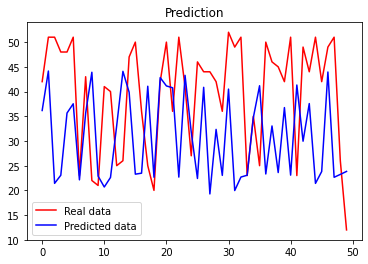

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly
import plotly.express as px # for data visualization
import seaborn as sns

generator_multiply = 100 #each input record will generate 100 random vectors from the latent space, given the mu and sigma generated by the encoder

#from keras.utils import plot_model
#import matplotlib.pyplot as plt

#window1 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-500.npy')
#window2 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-1000.npy')
#window = np.concatenate((window1, window2), axis=0)
#train_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TRAIN.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TEST.npy')



#get data
train_data = np.load(r'/content/drive/MyDrive/PHD/2021/DATAFILES/multivariate_long_sequences-TRAIN.npy')
test_data = np.load(r'/content/drive/MyDrive/PHD/2021/DATAFILES/multivariate_long_sequences-TEST.npy')
#all_data = np.concatenate((train_data,test_data),axis=0)
window_label = np.load(r'/content/drive/MyDrive/PHD/2021/DATAFILES/WINDOW_LABELLED.npy')
n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]


plt.suptitle('Sub sequence plotting', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Feature 1', fontsize='20')
plt.plot(train_data[:,:,1])
plt.show()

encoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2021/vae-encoder-saved.model')
decoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2021/vae-decoder-saved.model')

X_train_encoded = encoder.predict(train_data)
mu, logvar, z = X_train_encoded
sigma = tf.exp(0.5 * logvar)
batch = tf.shape(mu)[0]  #number of recors / batchs
dim = tf.shape(mu)[1] #Ndimension of latent variable
store = list()
storetemp = list()
#For each batch, iterate, get the generator_multipy number of latent vectors with same window_size

for i in range(0,batch):
  all_Z_i = tf.random.normal(shape=(generator_multiply,dim), mean = mu[i,:], stddev=sigma[i,:]) #all randorm vectors for this record i
  a = np.arange(generator_multiply)
  a.fill(window_label[i])
  c=np.concatenate(((all_Z_i,a[:,None])),axis=1)
  store.append(c)

results=np.concatenate(store,axis=0)

#Regression fitting
x=results[:,:-1]
y=results[:,2]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

###### Random forrest ergression
from sklearn.ensemble import RandomForestRegressor
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 0)
# fit the regressor with x and y data
regressor.fit(x_train,y_train)
y_pred = regressor.predict(x_test)  # test the output by changing values
# creating an object of LinearRegression class
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_pred)
print("r2 score is ==",score)
print("mean_sqrd_error is==",mean_squared_error(y_test,y_pred))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_test,y_pred)))
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');


sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#################  ANN to do regression###########################
#######  https://stackoverflow.com/questions/49008074/how-to-create-a-neural-network-for-regression  #######################
###########  Nh = Ns/(α∗ (Ni + No)) ##########################
from keras.layers import Dense, Activation
from keras.models import Sequential

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(128, activation = 'relu', input_dim = 2))

# Adding the second hidden layer
model.add(Dense(units = 64, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

# Fitting the ANN to the Training set
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
model.fit(x_train, y_train, epochs=100, batch_size=20, verbose=1, validation_split=0.2)


y_pred = model.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_pred)
print("r2 score is ==",score)
print("mean_sqrd_error is==",mean_squared_error(y_test,y_pred))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_test,y_pred)))
#plt.scatter(y_test,y_pred);
#plt.xlabel('Actual');
#plt.ylabel('Predicted');
plt.plot(y_test[0:50], color = 'red', label = 'Real data')
plt.plot(y_pred[0:50], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

